In [1]:
from tifffile import imread
import os
from matplotlib import pyplot as plt
import json
from scipy.io import loadmat
import h5py
import numpy as np

In [2]:
pth_WSI_segmentations = r'\\10.99.68.178\andre\Eduarda PDAC\immune_cell_pipeline\star_dist_Donald_model\StarDist_1_29_23\json'
npdi_im_path = r'\\10.99.68.178\andre\Eduarda PDAC\immune_cell_pipeline\star_dist_Donald_model'

In [3]:
json_pth_list = [os.path.join(pth_WSI_segmentations,file) for file in os.listdir(pth_WSI_segmentations) if file.endswith(".json")]
print(json_pth_list)

['\\\\10.99.68.178\\andre\\Eduarda PDAC\\immune_cell_pipeline\\star_dist_Donald_model\\StarDist_1_29_23\\json\\OM1R_618.json']


In [4]:
im_list = os.listdir(npdi_im_path)
im_list = [im for im in im_list if im.endswith('.ndpi')]

In [5]:
# read one image
ind = 0

HE_20x_WSI = imread(os.path.join(npdi_im_path, im_list[ind]))

In [14]:
crop_x = 24917 - 500
crop_y = 28149 - 500
tile_size = 512*2

HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

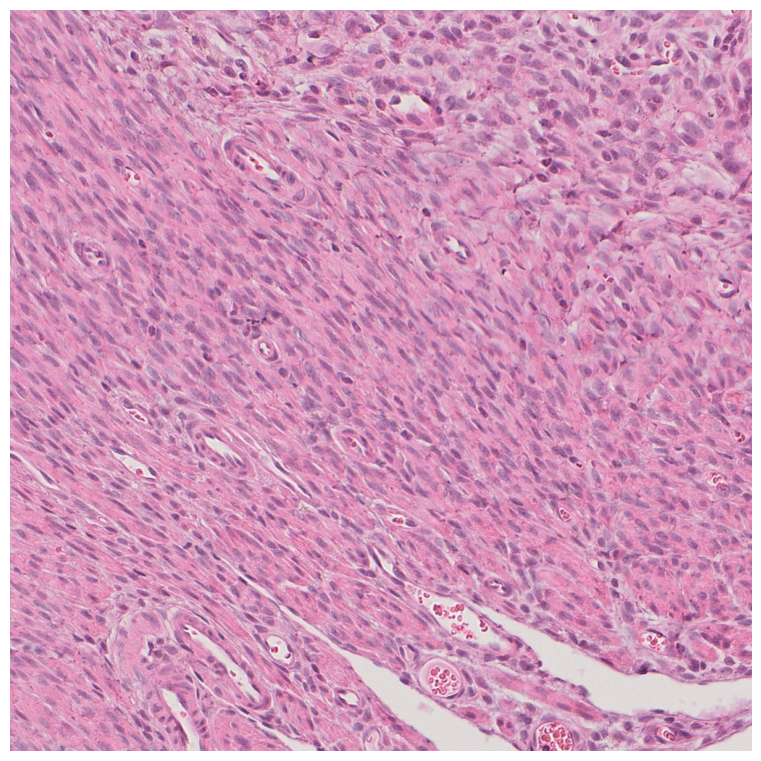

In [15]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()
    
show_tile(HE_20x_tile)

In [11]:
geo_data = json.load(open(geojson_file))
print(geo_data.keys())

dict_keys(['type', 'features'])


In [12]:
centroids_ann = []

for i in range(len(geo_data['features'])):
    data = geo_data['features'][i]
    coords = data['geometry']['coordinates'][0]
    
    x_cent = 0
    y_cent = 0
    for pair in coords:
        x_cent += pair[1] + crop_y
        y_cent += pair[0] + crop_x
    x_cent /= len(coords)
    y_cent /= len(coords)
    
    # print(x_cent, y_cent)
    centroids_ann.append([x_cent, y_cent])

In [13]:
segmentation_data = json.load(open(json_pth_list[ind]))

centroids = [nuc['centroid'][0] for nuc in segmentation_data]
contours = [nuc['contour'] for nuc in segmentation_data]
print(len(centroids))
print(len(contours))

300094
300094


In [14]:
print(centroids[:5])

[[3604, 780], [3962, 2652], [1910, 3950], [2534, 6248], [2182, 6642]]


In [15]:
centroids_ann_np = np.array(centroids_ann)
centroids_total_np = np.array(centroids)

print(len(centroids_ann_np))
print(len(centroids_total_np))

118
300094


In [16]:
results = colocalize_points(centroids_ann_np, centroids_total_np, r=20)

In [17]:
centroids_annotated = [centroids_ann_np[i] for i in results[0]]
centroids_all = [centroids_total_np[i] for i in results[1]]

In [18]:
centroids_matched = [pair.tolist() for pair in centroids_all]

adj_centroids_matched = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids_matched]

adj_centroids = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids]
centroids_in_tile_seg = [pair for pair in adj_centroids if 0 < crop_y < tile_size and 0 < crop_x < tile_size and pair not in adj_centroids_matched]

indices_matched = [adj_centroids.index(pair) for pair in adj_centroids if pair in adj_centroids_matched]

indices_not_matched = [adj_centroids.index(pair) for pair in adj_centroids if 0 < pair[1] < tile_size and 0 < pair[0] < tile_size and pair not in adj_centroids_matched]  # and within crop range

print(len(indices_matched))
print(len(indices_not_matched))

115
4497


In [19]:
def adjust_contours(contours_matched, x, y):

    contours_matched_adjusted = []
    for i in range(len(contours_matched)):
        contour = contours_matched[i][0]
        x_coords = contour[0]
        y_coords = contour[1]
        x_coords = [point-x for point in x_coords]
        y_coords = [point-y for point in y_coords]
        
        shape = list(zip(x_coords, y_coords))
        contours_matched_adjusted.append(shape)
    
    return contours_matched_adjusted

In [20]:
contours_matched = [contours[i] for i in indices_matched]
contours_not_matched = [contours[i] for i in indices_not_matched] 

contours_matched_adjusted = adjust_contours(contours_matched, crop_y, crop_x)
contours_not_matched_adjusted = adjust_contours(contours_not_matched, crop_y, crop_x)

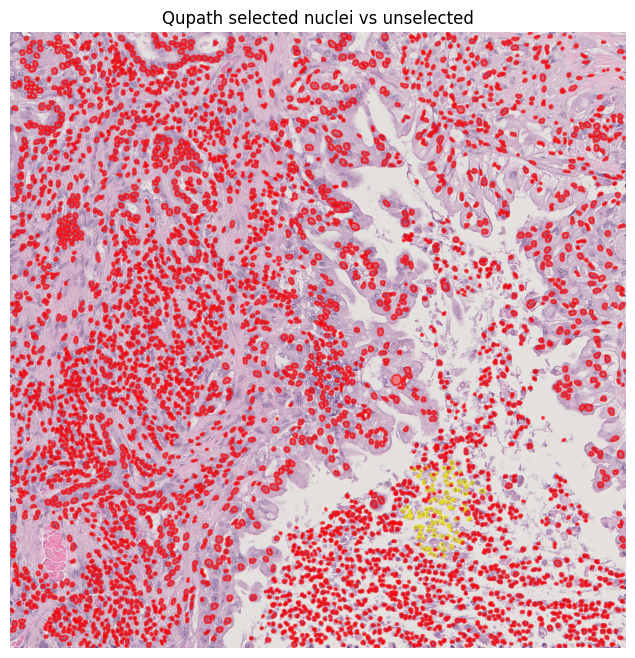

In [21]:
reversed_contours = [[(y, x) for x, y in polygon] for polygon in contours_matched_adjusted]

reversed_contours_negative = [[(y, x) for x, y in polygon] for polygon in contours_not_matched_adjusted]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot the image
ax.imshow(HE_20x_tile)
ax.set_axis_off()

# Plot each reversed polygon on the same image
for polygon in reversed_contours:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'yellow'

    ax.plot(x_coords, y_coords, alpha=0.3, color=color)
    ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon
    
# Plot each reversed polygon on the same image
for polygon in reversed_contours_negative:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'
    
    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.4, color=color)
        ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Qupath selected nuclei vs unselected')

plt.show()

In [22]:
# trying to get intensity inside those pixels now:

len(contours_matched)

115

In [23]:
import cv2

In [24]:
np.max(np.array(HE_20x_tile, dtype=np.uint8))

255

In [25]:
print(len(contours))

300094


In [26]:
contours_fixed = []
for polygon in contours:
    coords = np.array([list(zip(x,y)) for x,y in [polygon[0]]][0], dtype=np.int32)
    contours_fixed.append(coords)
    
contours_fixed = np.array(contours_fixed)

In [27]:
print(len(contours_fixed))
print(contours_fixed[0])

300094
[[3603  783]
 [3602  782]
 [3601  783]
 [3601  782]
 [3601  781]
 [3601  781]
 [3601  780]
 [3601  780]
 [3601  779]
 [3601  779]
 [3601  778]
 [3602  778]
 [3602  778]
 [3603  778]
 [3603  777]
 [3604  777]
 [3604  777]
 [3604  777]
 [3605  777]
 [3606  777]
 [3606  778]
 [3606  778]
 [3606  779]
 [3606  780]
 [3606  780]
 [3606  781]
 [3606  781]
 [3606  782]
 [3605  782]
 [3604  782]
 [3604  782]
 [3604  783]]


In [28]:
height, width, _ = np.shape(HE_20x_WSI)

intensities = cv2.drawContours(HE_20x_WSI, contours_fixed[0:1000], -1, (0,255,0), -1)

In [29]:
intensities.shape

(39424, 46080, 3)

In [30]:
np.max(intensities[:,:,2])

255

In [31]:
print(contours_fixed[0])

[[3603  783]
 [3602  782]
 [3601  783]
 [3601  782]
 [3601  781]
 [3601  781]
 [3601  780]
 [3601  780]
 [3601  779]
 [3601  779]
 [3601  778]
 [3602  778]
 [3602  778]
 [3603  778]
 [3603  777]
 [3604  777]
 [3604  777]
 [3604  777]
 [3605  777]
 [3606  777]
 [3606  778]
 [3606  778]
 [3606  779]
 [3606  780]
 [3606  780]
 [3606  781]
 [3606  781]
 [3606  782]
 [3605  782]
 [3604  782]
 [3604  782]
 [3604  783]]


In [32]:
len(contours_fixed[0])

32

In [33]:
len(centroids)

300094

In [34]:
import copy

def adjust_contours_2(contour, crop_x, crop_y):

    for i, xy in enumerate(contour):
        x = xy[0] - crop_x
        y = xy[1] - crop_y
        
        
        contour[i] = [x, y]
    return contour

In [37]:
r_avg_list = []
g_avg_list = []
b_avg_list = []

# trying new approach by cropping im each time:
for i in range(len(contours_fixed)):
    centroid = centroids[i]
    contour_raw = copy.copy(contours_fixed[i])
    
    offset = 20
    
    x_low = centroid[0] - offset
    x_high = centroid[0] + offset
    y_low = centroid[1] - offset
    y_high = centroid[1] + offset

    im_crop = HE_20x_WSI[x_low:x_high, y_low:y_high]
    
    contour_adj = adjust_contours_2(contour_raw, centroid[0]-offset-1, centroid[1]-offset-1)
    contour = contour_adj.reshape((-1,1,2)).astype(np.int32)
    rev_contour = contour[:,:, [1, 0]]  # its backwards for some reason idk why but you need to flip it like this
    
    
    #print(im_crop.shape)
    #print(centroid)
    #plt.imshow(im_crop)
    #cv2.drawContours(im_crop, [rev_contour], -1, (0,255,0), thickness=cv2.FILLED)
    
    # plt.imshow(im_crop)
    
    
    
    # Create a single-channel mask
    mask = np.zeros_like(im_crop[:, :, 0], dtype=np.uint8)  # make black image of same size, will fill with mask

    # Draw contours on the single-channel mask
    cv2.drawContours(mask, [rev_contour], 0, (1), thickness=cv2.FILLED)
    
    r_pixels = im_crop[:,:,0] * mask
    g_pixels = im_crop[:,:,1] * mask
    b_pixels = im_crop[:,:,2] * mask
    
    num_pixels = np.count_nonzero(mask)
    
    # print(num_pixels)
    
    r_avg = round(np.sum(r_pixels)/num_pixels,2)
    g_avg = round(np.sum(g_pixels)/num_pixels,2)
    b_avg = round(np.sum(b_pixels)/num_pixels,2)
    
    # print(r_avg)
    
    # plt.imshow(im_crop)
    
    r_avg_list.append(r_avg)
    g_avg_list.append(g_avg)
    b_avg_list.append(b_avg)
    

In [38]:
print(len(r_avg_list))

300094


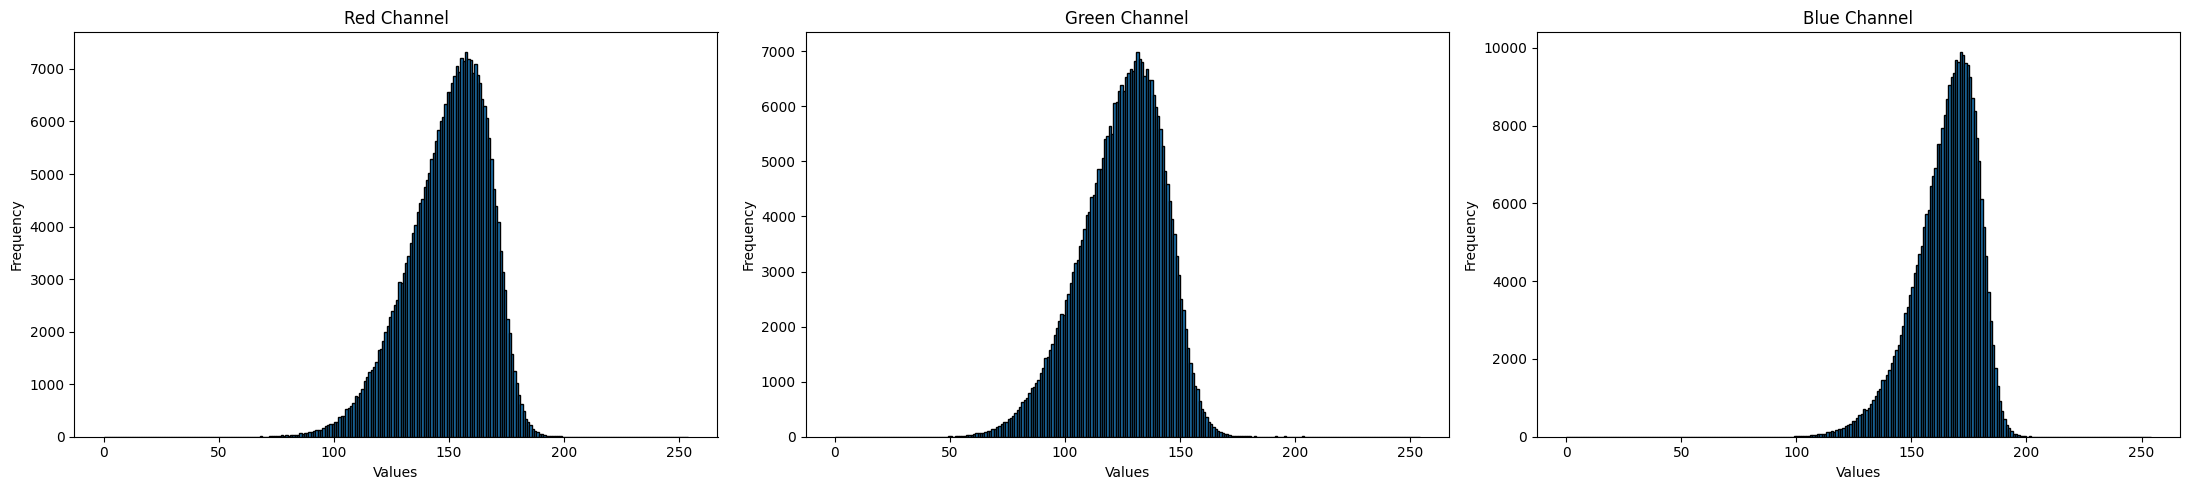

In [47]:
plt.figure(figsize=(22, 5))

# Plot for Red channel
plt.subplot(1, 3, 1)
plt.hist(r_avg_list, bins=range(0, 255), edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Red Channel')

# Plot for Green channel
plt.subplot(1, 3, 2)
plt.hist(g_avg_list, bins=range(0, 255), edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Green Channel')

# Plot for Blue channel
plt.subplot(1, 3, 3)
plt.hist(b_avg_list, bins=range(0, 255), edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Blue Channel')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the histogram
plt.show()

In [62]:
print(len(indices_matched))
print(len(r_avg_list))

115
300094


In [67]:
print(len(indices_not_matched))

4497


In [63]:
neutrophil_r_avg_list = [r_avg_list[i] for i in indices_matched]
neutrophil_g_avg_list = [g_avg_list[i] for i in indices_matched]
neutrophil_b_avg_list = [b_avg_list[i] for i in indices_matched]

len(neutrophil_r_avg_list)

115

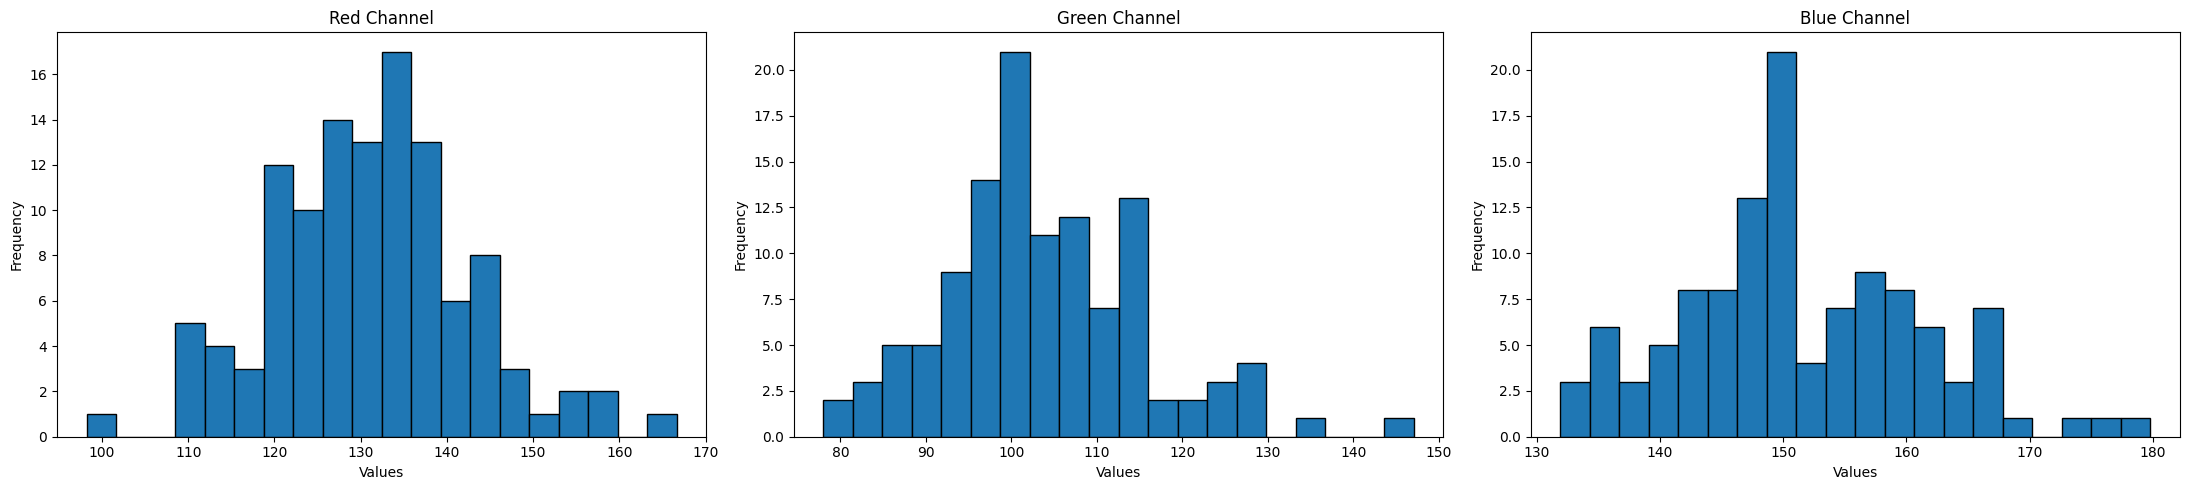

In [64]:
plt.figure(figsize=(22, 5))

# Plot for Red channel
plt.subplot(1, 3, 1)
plt.hist(neutrophil_r_avg_list, bins=20, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Red Channel')

# Plot for Green channel
plt.subplot(1, 3, 2)
plt.hist(neutrophil_g_avg_list, bins=20, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Green Channel')

# Plot for Blue channel
plt.subplot(1, 3, 3)
plt.hist(neutrophil_b_avg_list, bins=20, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Blue Channel')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the histogram
plt.show()

Get df of features of nuc morphology

In [68]:
import pandas as pd
import cv2

In [69]:
# def json2df():
def cntarea(cnt):
    cnt = np.array(cnt).astype(np.float32)
    area = cv2.contourArea(cnt)
    return area

def cntperi(cnt):
    cnt = np.array(cnt).astype(np.float32)
    perimeter = cv2.arcLength(cnt,True)
    return perimeter

def cntMA(cnt):
    cnt = np.array(cnt).astype(np.float32)
    #Orientation, Aspect_ratio
    [(x,y),(MA,ma),orientation] = cv2.fitEllipse(cnt)
    return [np.max((MA,ma)),np.min((MA,ma)),orientation]

In [70]:
outpth = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\json\features_pickle\test_w_colors.pickle'
# print(outpth)

if not os.path.exists(outpth):
    data = segmentation_data

    centroids = []
    contours = []

    for entry in data:
        cent = entry['centroid'][0]
        centroids.append(cent)
        c = entry['contour'][0]
        contour = []
        for j in range(len(c[0])):
            point = [c[0][j], c[1][j]]
            contour.append(point)
        contours.append(contour)

    centroids = np.array(centroids)
    contours = np.array(contours)

    if len(centroids) == 0:
        print(f'Skipping')
    else:

        areas = []
        perimeters = []
        circularities = []
        aspect_ratios = []
        image_ids = []
        classes = []

        compactness_a, eccentricity_a, euler_number_a, extent_a, form_factor_a, maximum_radius_a, mean_radius_a, median_radius_a, minor_axis_length_a, orientation_degrees_a = [], [], [], [], [], [], [], [], [], []

        for j, centroid in enumerate(centroids):
            contour = contours[j]
            area = cntarea(contour)
            perimeter = cntperi(contour)
            circularity = 4 * np.pi * area / perimeter ** 2
            MA = cntMA(contour)
            [MA, ma, orientation] = MA
            aspect_ratio = MA / ma
            center_x = centroid[0]
            center_y = centroid[1]

            # Additional features
            compactness = perimeter ** 2 / area
            eccentricity = np.sqrt(1 - (ma / MA) ** 2)
            extent = area / (MA * ma)
            form_factor = (perimeter ** 2) / (4 * np.pi * area)
            major_axis_length = MA
            maximum_radius = np.max(np.linalg.norm(contour - centroid, axis=1))
            mean_radius = np.mean(np.linalg.norm(contour - centroid, axis=1))
            median_radius = np.median(np.linalg.norm(contour - centroid, axis=1))
            minor_axis_length = ma
            orientation_degrees = np.degrees(orientation)

            areas.append(area)
            perimeters.append(perimeter)
            circularities.append(circularity)
            aspect_ratios.append(aspect_ratio)

            # additional features
            compactness_a.append(compactness)
            eccentricity_a.append(eccentricity)
            extent_a.append(extent)
            form_factor_a.append(form_factor)
            maximum_radius_a.append(maximum_radius)
            mean_radius_a.append(mean_radius)
            median_radius_a.append(median_radius)
            minor_axis_length_a.append(minor_axis_length)
            orientation_degrees_a.append(orientation_degrees)

        dat = {
            'Centroid_x': centroids[:,0],
            'Centroid_y': centroids[:,1],
            'Area': areas,
            'Perimeter': perimeters,
            'Circularity': circularities,
            'Aspect Ratio': aspect_ratios,
            'compactness' : compactness_a,
            'eccentricity' : eccentricity_a,
            'extent' : extent_a,
            'form_factor' : form_factor_a,
            'maximum_radius' : maximum_radius_a,
            'mean_radius' : mean_radius_a,
            'median_radius' : median_radius_a,
            'minor_axis_length' : minor_axis_length_a,
            'orientation_degrees' : orientation_degrees_a,
        }

        df = pd.DataFrame(dat)

        # df.to_pickle(outpth)

In [71]:
df.head()

,Centroid_x,Centroid_y,Area,Perimeter,Circularity,Aspect Ratio,compactness,eccentricity,extent,form_factor,maximum_radius,mean_radius,median_radius,minor_axis_length,orientation_degrees
0,3604,780,26.049731,20.469619,0.781256,1.258728,16.084823,0.607326,0.754252,1.279990,3.795808,2.868693,2.835281,5.238143,2955.370398
1,3962,2652,35.321628,22.885312,0.847495,1.387624,14.827671,0.693292,0.762484,1.179949,4.350932,3.289612,3.432316,5.777888,965.269654
2,1910,3950,22.447227,18.327221,0.839807,1.274382,14.963409,0.619883,0.763346,1.190750,4.110146,2.616106,2.444243,4.803643,8471.705909
3,2534,6248,118.837506,40.530715,0.909065,1.505144,13.823404,0.747387,0.773084,1.100032,9.892186,6.000134,5.364367,10.105887,4132.186201
4,2182,6642,26.123885,20.266575,0.799258,1.135791,15.722549,0.474151,0.748013,1.251161,3.884122,2.837054,2.764145,5.545172,3048.745095


In [74]:
# add rbg mean intensity cols to df:
df2 = df.copy()

df2['R_avg_intensity'] = r_avg_list
df2['G_avg_intensity'] = g_avg_list
df2['B_avg_intensity'] = b_avg_list

In [75]:
len(df)

300094

In [78]:
features_df = df2[[
            'Area',
            'Perimeter',
            #'Circularity',
            'Aspect Ratio',
            'compactness',
            #'eccentricity',
            'extent',
            'form_factor',
            'maximum_radius',
            #'mean_radius',
            #'median_radius',
            #'minor_axis_length',
            #'orientation_degrees',
            'R_avg_intensity',
            'G_avg_intensity',
            'B_avg_intensity'
]]
features_df.head()

,Area,Perimeter,Aspect Ratio,compactness,extent,form_factor,maximum_radius,R_avg_intensity,G_avg_intensity,B_avg_intensity
0,26.049731,20.469619,1.258728,16.084823,0.754252,1.279990,3.795808,178.84,179.32,188.78
1,35.321628,22.885312,1.387624,14.827671,0.762484,1.179949,4.350932,109.67,120.33,139.76
2,22.447227,18.327221,1.274382,14.963409,0.763346,1.190750,4.110146,189.19,195.66,195.44
3,118.837506,40.530715,1.505144,13.823404,0.773084,1.100032,9.892186,153.76,154.02,155.83
4,26.123885,20.266575,1.135791,15.722549,0.748013,1.251161,3.884122,158.90,152.68,173.78


In [132]:
# I want to separate df by nuc that I annotated vs nuc that I didn't annotate:
features_df_matched = features_df.loc[df.index.isin(indices_matched)]
features_df_others = features_df.loc[~df.index.isin(indices_matched)]

print(len(features_df_matched))
print(len(features_df_others))

115
299979


In [133]:
# now I'll just add them to the end of this subsampled df so that I still know their indicies
sample_features_df = features_df_others.sample(frac=0.2)
len_sample = len(sample_features_df)
print(len_sample)

sample_features_df

# Get the remaining 80% of the data
remaining_features_df = features_df_others.drop(sample_features_df.index)

59996


In [134]:
combined_df = pd.concat([sample_features_df, features_df_matched], axis=0)
print(len(combined_df))

60111


In [135]:
sample_features_df.head()

,Area,Perimeter,Aspect Ratio,compactness,extent,form_factor,maximum_radius,R_avg_intensity,G_avg_intensity,B_avg_intensity
42709,97.275785,39.011774,1.453904,15.645399,0.732986,1.245021,8.853066,120.84,99.51,145.99
293223,41.794029,26.518497,1.916498,16.826104,0.742901,1.338979,7.870626,152.05,127.18,162.75
63508,61.097007,30.200122,1.155609,14.927856,0.753047,1.187921,5.254081,109.64,84.21,130.63
3460,305.030805,66.636307,1.831885,14.557210,0.774041,1.158426,14.385919,140.99,112.15,156.36
242507,71.192657,35.595614,2.136035,17.797449,0.750356,1.416276,9.727560,146.19,131.64,175.36


In [136]:
combined_df.head()

,Area,Perimeter,Aspect Ratio,compactness,extent,form_factor,maximum_radius,R_avg_intensity,G_avg_intensity,B_avg_intensity
42709,97.275785,39.011774,1.453904,15.645399,0.732986,1.245021,8.853066,120.84,99.51,145.99
293223,41.794029,26.518497,1.916498,16.826104,0.742901,1.338979,7.870626,152.05,127.18,162.75
63508,61.097007,30.200122,1.155609,14.927856,0.753047,1.187921,5.254081,109.64,84.21,130.63
3460,305.030805,66.636307,1.831885,14.557210,0.774041,1.158426,14.385919,140.99,112.15,156.36
242507,71.192657,35.595614,2.136035,17.797449,0.750356,1.416276,9.727560,146.19,131.64,175.36


In [137]:
indices = range(len_sample,len(combined_df))
print(indices)

range(59996, 60111)


In [138]:
import pandas as pd

# Assuming 'combined_df' is a DataFrame containing your data

# Get the list of features from combined_df
features = combined_df.columns

quantiles_5_to_95 = combined_df[features].iloc[indices].quantile([0.05, 0.95])

# Print or use the quantiles as needed
print("10% to 90% Quantiles:")
print(quantiles_5_to_95)


10% to 90% Quantiles:
            Area  Perimeter  Aspect Ratio  compactness    extent  form_factor  \
0.05   35.378249  23.754877      1.078788    13.857231  0.735634     1.102723   
0.95  108.127928  40.218173      1.869966    17.302833  0.770896     1.376916   

      maximum_radius  R_avg_intensity  G_avg_intensity  B_avg_intensity  
0.05        4.380077          111.856           86.173          135.634  
0.95        9.108650          148.430          125.799          167.226  


In [139]:
len(combined_df)

60111

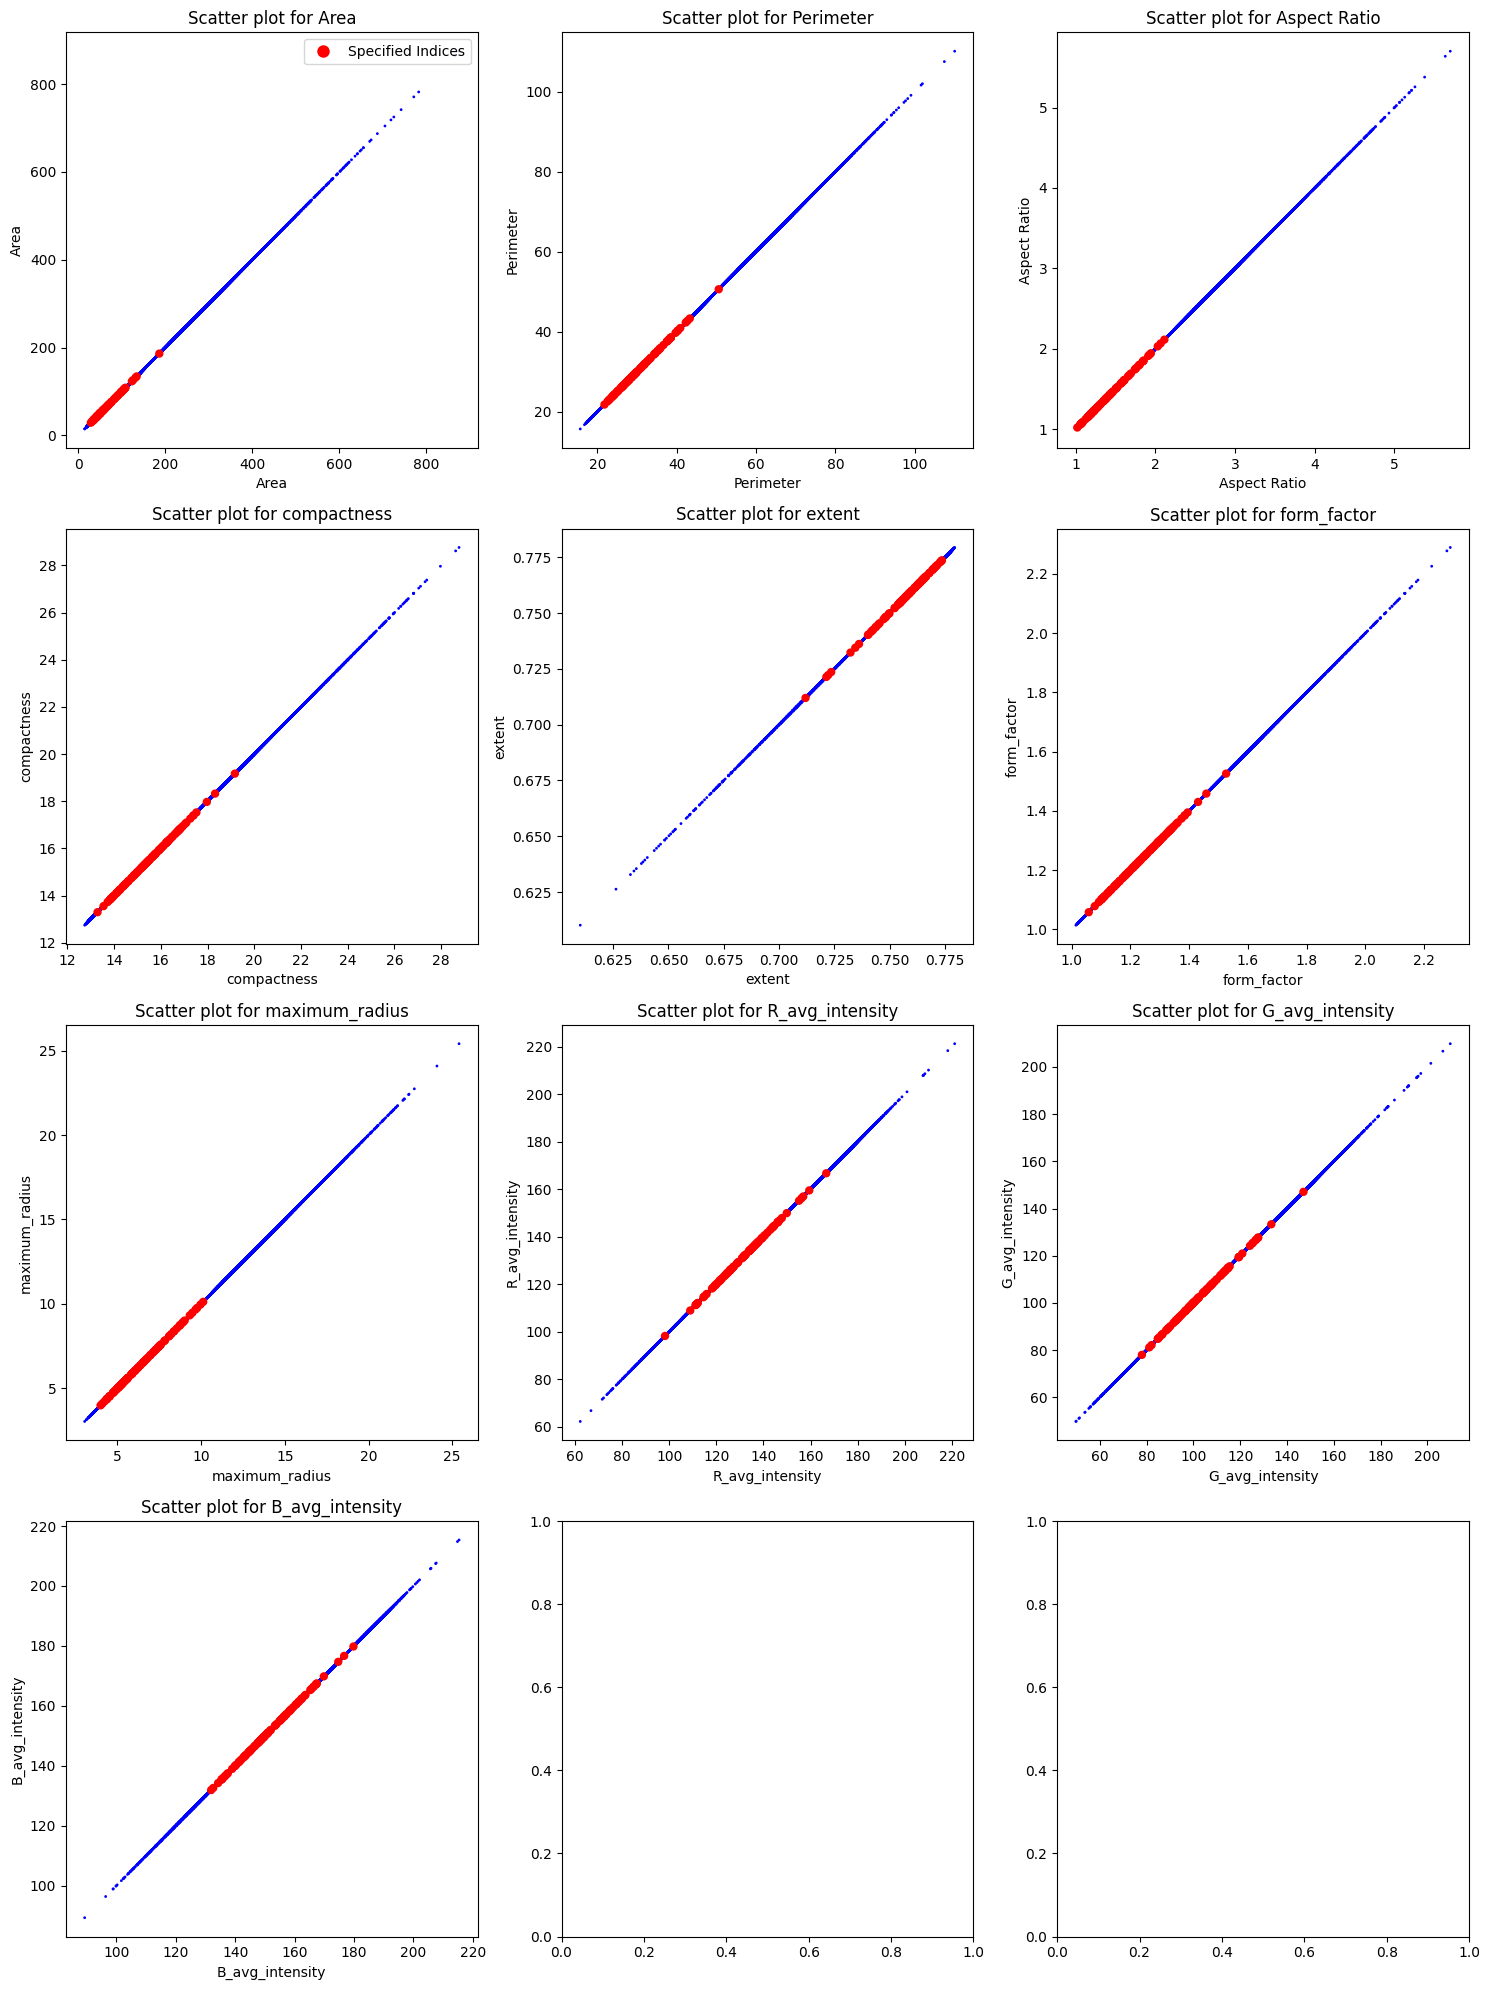

In [140]:
# Get the list of features from combined_df
features = combined_df.columns

# Set up subplots
num_features = len(features)
num_cols = 3  # You can adjust the number of columns based on your preference
num_rows = (num_features + num_cols - 1) // num_cols

features = combined_df.columns

# Set up subplots
num_features = len(features)
num_cols = 3  # You can adjust the number of columns based on your preference
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate through each feature and create a scatter plot
for i, feature in enumerate(features):
    ax = axes[i // num_cols, i % num_cols]
    
    # Define colors and sizes based on indices
    colors = ['red' if j in indices else 'blue' for j in range(len(combined_df))]
    sizes = [25 if j in indices else 1 for j in range(len(combined_df))]
    
    # Plot the scatter plot for the current feature
    scatter = ax.scatter(combined_df[feature], combined_df[feature], c=colors, s=sizes)
    ax.set_title(f'Scatter plot for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel(feature)
    
    # Add legend for clarity
    if i == 0:
        ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Specified Indices')],
                  loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

In [141]:
y_train = [1 if i in indices else 0 for i in range(len(combined_df))]

In [142]:
import umap  # https://umap.scikit-tda.org/transform.html
import matplotlib.pyplot as plt

trans = umap.UMAP(n_components=2, random_state=42).fit(combined_df)

C:\Users\Donald\anaconda3\envs\monkey_nuc_segment_v6\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


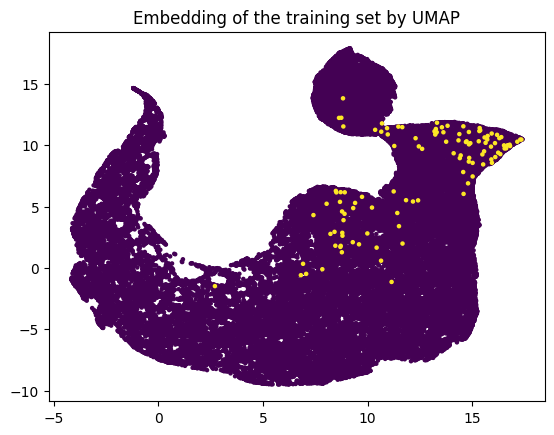

In [143]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train)
plt.title('Embedding of the training set by UMAP', fontsize=12);

In [90]:
transformed_rest_df = trans.transform(remaining_features_df)

In [150]:
from sklearn.cluster import KMeans

# Apply K-means clustering with 3 clusters
kmeans_model = KMeans(n_clusters=5)
clusters = kmeans_model.fit_predict(trans.embedding_)

C:\Users\Donald\anaconda3\envs\monkey_nuc_segment_v6\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [151]:
len(clusters)

60111

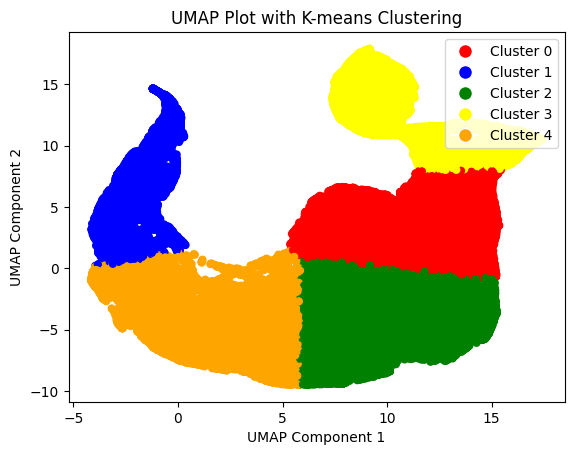

In [162]:
# Define colors and sizes based on cluster labels
colors = ['red' if cluster == 0 else 'blue' if cluster == 1 else 'green' for cluster in clusters]
colors = ['red' if cluster == 0 else 'blue' if cluster == 1 else 'green' if cluster == 2 else 'yellow' if cluster == 3 else 'orange' for cluster in clusters]
#colors = ['red' if cluster == 0 else 'blue' if cluster == 1 else 'green' if cluster == 2 else 'orange' for cluster in clusters]
sizes = [25 for _ in range(len(combined_df))]  # Adjust the size if needed

# Plot the transformed features using UMAP with different colors and sizes for clusters
scatter = plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=colors, s=sizes)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot with K-means Clustering')

# Add a legend for clarity
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cluster 0'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cluster 1'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Cluster 2'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Cluster 3'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Cluster 4')],
           loc='upper right')

plt.show()

In [163]:
predictions = kmeans_model.predict(transformed_rest_df)

In [165]:
print(f'0: {sum(predictions == 0)}')
print(f'1: {sum(predictions == 1)}')
print(f'2: {sum(predictions == 2)}')
print(f'3: {sum(predictions == 3)}')
print(f'4: {sum(predictions == 4)}')

0: 16780
1: 109263
2: 30208
3: 8717
4: 75015


In [156]:
indices_cluster_0 = (predictions == 0).nonzero()[0]
print(len(indices_cluster_0))

16780


In [157]:
df_combined_w_cluster = pd.concat([combined_df, remaining_features_df], ignore_index=True)
print(len(df_combined_w_cluster))

df_combined_w_cluster['Cluster'] = np.concatenate((clusters, predictions))

300094


In [158]:
df_combined_w_cluster.head()

,Area,Perimeter,Aspect Ratio,compactness,extent,form_factor,maximum_radius,R_avg_intensity,G_avg_intensity,B_avg_intensity,Cluster
0,97.275785,39.011774,1.453904,15.645399,0.732986,1.245021,8.853066,120.84,99.51,145.99,0
1,41.794029,26.518497,1.916498,16.826104,0.742901,1.338979,7.870626,152.05,127.18,162.75,3
2,61.097007,30.200122,1.155609,14.927856,0.753047,1.187921,5.254081,109.64,84.21,130.63,0
3,305.030805,66.636307,1.831885,14.557210,0.774041,1.158426,14.385919,140.99,112.15,156.36,1
4,71.192657,35.595614,2.136035,17.797449,0.750356,1.416276,9.727560,146.19,131.64,175.36,0


In [160]:
print(len(contours))

300094


In [167]:
indices_cluster_3 = (predictions == 3).nonzero()[0]
print(len(indices_cluster_3))

good_contours = contours[indices_cluster_3]
print(len(good_contours))

8717
8717


In [168]:
GEOdata = []

for contour in good_contours:
    contour = [[coord for coord in xy[::-1]] for xy in contour]
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)

In [169]:
import geojson

outpth = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\test_immune_cells\immune_w_color.geojson'

with open(outpth,'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished')

Finished


In [ ]:
import umap  # https://umap.scikit-tda.org/transform.html
import matplotlib.pyplot as plt

# Create UMAP model with 2 components
umap_model = umap.UMAP(n_components=2)
transformed_features_umap = umap_model.fit_transform(combined_df)

# Define colors and sizes based on indices
colors = ['red' if i in indices else 'blue' for i in range(len(combined_df))]
sizes = [25 if i in indices else 1 for i in range(len(combined_df))]

# Plot the transformed features using UMAP with different colors and sizes for specified indices
scatter = plt.scatter(transformed_features_umap[:, 0], transformed_features_umap[:, 1], c=colors, s=sizes)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot')

# Add a legend for clarity
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Specified Indices')],
           loc='upper right')

plt.show()



In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering with 3 clusters
kmeans_model = KMeans(n_clusters=3)
clusters = kmeans_model.fit_predict(transformed_features_umap)

# Define colors and sizes based on cluster labels
colors = ['red' if cluster == 0 else 'blue' if cluster == 1 else 'green' for cluster in clusters]
sizes = [25 for _ in range(len(combined_df))]  # Adjust the size if needed

# Plot the transformed features using UMAP with different colors and sizes for clusters
scatter = plt.scatter(transformed_features_umap[:, 0], transformed_features_umap[:, 1], c=colors, s=sizes)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot with K-means Clustering')

# Add a legend for clarity
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cluster 0'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cluster 1'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Cluster 2')],
           loc='upper right')

plt.show()

In [ ]:
cluster_0_indices = [index for index, cluster_label in enumerate(clusters) if cluster_label == 0]

# Display the indices of Cluster 0
print("Indices of Cluster 0:", len(cluster_0_indices))

In [ ]:
# trying brute force approach

q_Area = [64.844785,127.798974]
q_Perimeter = [31.110758,42.056153]
q_Aspect_Ratio = [1.064367,1.577907]
q_compactness = [13.068521,15.302649]
q_extent = [0.757991,0.777657]
q_form_factor = [1.039960,1.217746]
q_maximum_radius = [5.620915,8.921496]

mask_Area = (features_df['Area'] >= q_Area[0]) & (features_df['Area'] <= q_Area[1])
mask_Perimeter = (features_df['Perimeter'] >= q_Perimeter[0]) & (features_df['Perimeter'] <= q_Perimeter[1])
mask_Aspect_Ratio = (features_df['Aspect Ratio'] >= q_Aspect_Ratio[0]) & (features_df['Aspect Ratio'] <= q_Aspect_Ratio[1])
mask_compactness = (features_df['compactness'] >= q_compactness[0]) & (features_df['compactness'] <= q_compactness[1])
mask_extent = (features_df['extent'] >= q_extent[0]) & (features_df['extent'] <= q_extent[1])
mask_form_factor = (features_df['form_factor'] >= q_form_factor[0]) & (features_df['form_factor'] <= q_form_factor[1])
mask_maximum_radius = (features_df['maximum_radius'] >= q_maximum_radius[0]) & (features_df['maximum_radius'] <= q_maximum_radius[1])

# Apply the masks to filter the DataFrame
subset_df = features_df[mask_Area & mask_Perimeter & mask_Aspect_Ratio & mask_compactness & mask_extent & mask_form_factor & mask_maximum_radius]

len(subset_df)

In [ ]:
good_indices = subset_df.index
good_indices[-5:]

In [ ]:
good_contours = contours[good_indices]

In [ ]:
GEOdata = []

for contour in good_contours:
    contour = [[coord for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)

In [ ]:
import geojson

outpth = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\test_immune_cells\test.geojson'

with open(outpth,'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished')